# 05c parameter optimisation 

In [1]:
#|default_exp core.05c_parameter_optimisation

In [2]:
#|export
import autograd.numpy as np
from autograd import grad, jacobian, hessian
from scipy.special import logsumexp
from scipy.optimize import minimize
import pandas as pd
from matplotlib import pyplot as plt

from dementia_inequalities import const, log, utils, tools 

---

In [3]:
#|export 
df_dem_plus = pd.read_csv(const.output_path+'/df_dem_plus.csv')

In [4]:
df_dem_plus.head()

,area_code,area_name,pop,DEM_afflicted,HYP_afflicted,DM_afflicted,STIA_afflicted,ALevel_plus,Female_all,Male_all,...,white_pc,DEM_afflicted_pc,ALevel_plus_pc,over_65_pc,female_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_contribution_to_LAD,GP_LAD_pc
0,E07000091,New Forest,151481,1858.546949,28892.139020,9338.695410,4466.648271,72749.0,91513.3596,84729.6073,...,93.2,1.226918,48.025165,34.275376,60.412434,19.073111,6.164929,2.948652,215.158147,0.001420
1,E09000027,Richmond upon Thames,156795,1016.262785,16263.714161,5723.913130,2019.443594,112919.0,101226.6730,93918.3682,...,63.0,0.648147,72.016965,20.177787,64.559886,10.372597,3.650571,1.287952,437.450820,0.002790
2,E07000116,Tunbridge Wells,95022,876.255260,12908.434533,4606.674451,1889.024705,52395.0,59540.1412,56126.1458,...,84.2,0.922160,55.139862,23.752404,62.659322,13.584680,4.848008,1.987987,123.466346,0.001299
3,E07000121,Lancaster,123214,1228.376774,16806.421220,6784.714317,2647.583108,65724.0,72615.6480,69496.5141,...,87.8,0.996946,53.341341,23.914299,58.934576,13.640026,5.506448,2.148768,612.399689,0.004970
4,E07000042,Mid Devon,67987,547.793487,10854.465333,4281.878984,1530.207441,33190.0,42541.3752,40639.6312,...,93.8,0.805733,48.818156,29.486050,62.572808,15.965501,6.298085,2.250735,77.360723,0.001138


In [5]:
# The real dementia x and y data 

# covariates 
covar = ['over_65_pc', 'female_pc', 'ALevel_plus_pc', 'white_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc']

# Input data 
x = np.array(df_dem_plus[covar].values.reshape(-1,7))

# Outcome data 
y = np.array(df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1))

In [6]:
# def shift_log_normal_pdf(x, delta, mu, sigma):
#     #pdf = np.zeros(x.shape[0])
#     pdf = []
#     for i, x_i in enumerate(x):
#         if isinstance(delta, int) or isinstance(delta, float):
#             delta = delta * np.ones(len(x)).T  

#         if x_i > delta[i]: 
#             pdf.append(0)
#             #pdf[i] = 0
#         else: 
#             x_shift = x_i-delta[i]
#             norm_const = 1 / ((x_shift) * sigma * np.sqrt(2 * np.pi))
#             exp_part = np.exp(-(1 / (2 * sigma ** 2)) * (np.log(np.subtract(x_shift, mu)) ** 2))
#             pdf.append(norm_const * exp_part)
#             #pdf[i] = norm_const * exp_part

#     return np.asarray(pdf)

def reverse_shift_log_normal_pdf(x, delta, mu, sigma):
    pdf = []
    #x_shift = delta - x
    for i, x_i in enumerate(x):
        #if isinstance(delta, int) or isinstance(delta, float):
        #    delta = delta * np.ones(len(x)).T  

        #if x_shift[i] < 0: 
        if delta[i] < x_i: 
            pdf.append(0)
        else: 
            x_shift = delta[i] - x_i
            norm_const = 1 / ((x_shift) * sigma * np.sqrt(2 * np.pi))
            exp_part = np.exp(-1 * (1 / (2 * sigma ** 2)) * (np.log(np.subtract(x_shift, mu)) ** 2))
            #exp_part = np.exp(-(np.log(np.subtract(x_shift, mu)) ** 2))
            pdf.append(norm_const.squeeze() * exp_part.squeeze())
            
    return np.array(pdf)

# def shift_log_normal_pdf(x, delta, mu, sigma):
#     pdf = []
#     for x_i in x:
#         print(x_i)
#         if x_i < delta:
#             pdf.append(0)
#         else: 
#             if isinstance(delta, int) or isinstance(delta, float):
#                 delta = delta * np.ones(len(x)).T
#             else:
#                 delta = delta.T
#             mu = mu * np.ones(len(x)).T
#             x_shift = np.subtract(x, delta)
#             norm_const = 1 / ((x_shift) * sigma * np.sqrt(2 * np.pi))
#             exp_part = np.exp(-(1 / (2 * sigma ** 2)) * (np.log(np.subtract(x_shift.squeeze(), mu.squeeze())) ** 2))
#             pdf.append(norm_const * exp_part)
#     return pdf

# Define the negative log-likelihood function for optimisation
# def neg_loglike(beta_0, beta, mu, sigma):
def neg_loglike(params):
    beta_0 = params[0]
    beta = np.array(params[1:-2])
    mu = params[-2]
    sigma = params[-1]

    y_pred = (np.dot(x, beta)).squeeze() + beta_0
    likelihood = reverse_shift_log_normal_pdf(y, delta=y_pred.squeeze(), mu=mu, sigma=sigma)
    #log_likelihood = np.nan_to_num(np.log(likelihood))
    log_likelihood = np.log(likelihood)
    
    return (-1 * np.sum(log_likelihood)).squeeze()
    #return log_likelihood

In [8]:
def log_norm_mode(mu:int, # mean of the variables log
                  sigma:int): # standard deviation of the variables log
    return np.exp(mu - sigma**2)

In [9]:
trial_params = np.array([0.25, 0.1, 0.004, -0.004, -0.003, 0.0157, -0.0138, 0.108, 0.0, 0.25])
jacobian_ = jacobian(neg_loglike)

print(neg_loglike(trial_params))
print(jacobian_(trial_params))

1456.266249108371
[  1768.67745796  44618.02814593 111641.54133364  88739.19989015
 143478.93221752  26369.373887    10600.19537135   3514.11767471
  -1611.45737294  -9820.0940818 ]


### Optimise the negative log likelihood 

We evaluate the log-likelihood using the maximise function from scikit-learn. This code is written with a little help from my firend ChatGPT - actually it generated the intial code - then I re-wrote 70% of it... 

*Note*: we need the likelihood to be the shifted log normal - which has an extra parameter (delta) compared to the log normal [see here](https://stats.stackexchange.com/questions/379980/understanding-the-shifted-log-normal-distribution). 

The shifted log-normal PDF at $x$ is: 

$$
p(x|x>\delta, \delta, \mu, \sigma) = 
\frac{1}{(x-\delta)\sigma \sqrt{2 \pi}} e^{-\frac{1}{2 \sigma^2}(ln(x- \delta)-\mu)^2}
$$

In the log-normal distribution, 
- $\mu$ is the scale parameter - it stretches and compresses
- $\sigma$ is a shape parameter - it controls how skewed/heavy tailed the distribution is. 

The shift is the linear equation: $\delta = \beta X$.

Since, we are taking $y_i$ to represent the observed diagnoses, and $\beta X$ to represent the expected a lower bound on the true prevalence rate the equation is: 

$$
y_{observed}=\beta X - \epsilon 
$$ 

Where $\epsilon > 0$. Now, accordingly the probability is: 

$$
p(y_{observed}|y_{observed} < \beta X, \beta, \mu, \sigma) = 
\frac{1}{(\beta X - y_{observed})\sigma \sqrt{2 \pi}} e^{-\frac{1}{2 \sigma^2}(ln(\beta X - y_{observed})-\mu)^2}
$$

And hence, the likelihood is: 

$$
L(\delta, \mu, \sigma) = \prod_{i=1}^n s(y_i | \beta X, \mu, \sigma) \\

= \prod_{i=1}^n \frac{1}{(y_i-\beta X_i)\sigma \sqrt{2 \pi}} e^{-\frac{1}{2 \sigma^2}(ln(y_i- \beta X_i)-\mu)^2}
$$

With a log-likelihood of: 

$$
= \sum_{i=1}^n log(\frac{1}{(y_i-\beta X_i)\sigma \sqrt{2 \pi}} e^{-\frac{1}{2 \sigma^2}(ln(y_i- \beta X_i)-\mu)^2})§
$$


/var/folders/4n/x6w1yfcx01qbymrsfpz4ybq00000gn/T/ipykernel_93899/147317058.py:32: RuntimeWarning: divide by zero encountered in scalar divide
  norm_const = 1 / ((x_shift) * sigma * np.sqrt(2 * np.pi))
/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/var/folders/4n/x6w1yfcx01qbymrsfpz4ybq00000gn/T/ipykernel_93899/147317058.py:35: RuntimeWarning: invalid value encountered in scalar multiply
  pdf.append(norm_const.squeeze() * exp_part.squeeze())


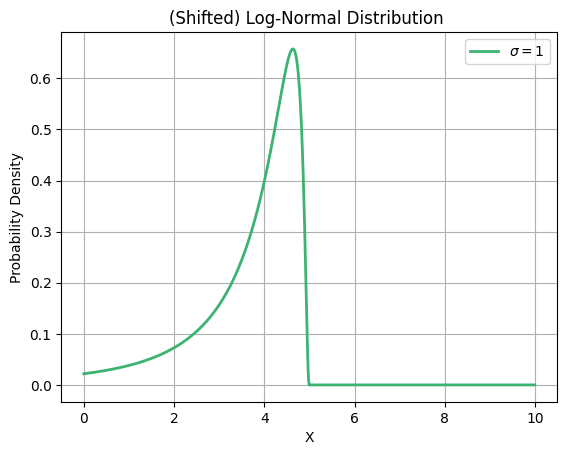

In [10]:
# Parameters for log-normal distribution
mu_0 = 0  # Mean
sigma_0 = 1
shift = 5 # Shift 

x_axis = np.arange(0, 10, 0.01)
shift = shift * np.ones(len(x_axis))

pdf_x_mu0 = reverse_shift_log_normal_pdf(x_axis, shift, mu_0, sigma_0)

# Plot the log-normal probability density function (PDF)
xmin, xmax = plt.xlim()
plt.plot(x_axis, pdf_x_mu0, '-', linewidth=2, color='mediumseagreen', label='$\sigma=1$')
#plt.text(6, 0.42, '$\sigma=1$', color='mediumseagreen')
#plt.plot(x, pdf_x_mu1, '-', linewidth=2, color='slateblue', label='$\sigma=0.25$')
#plt.text(7, 0.15, '$\sigma=0.25$', color='slateblue')

plt.title('(Shifted) Log-Normal Distribution ')
plt.legend(loc='upper right')
plt.xlabel('X')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

In [11]:
#n_features = 7

#np.random.seed(27)
#x0 = np.concatenate([np.random.normal(size=n_features+1), [0, 0.25]]) 

params_0 = np.array([0.25, 0.1, 0.004, -0.004, -0.003, 0.0157, -0.0138, 0.108, 0.0, 0.25])

In [12]:
# Gradient of the function
grad_loglike = grad(neg_loglike)

# Initial guess

# Use scipy's minimize function with the BFGS algorithm
result = minimize(neg_loglike, params_0, method = 'BFGS')

result

/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/autogra

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -42.75684435504523
        x: [ 2.508e-01  5.022e-02  7.967e-03 -1.954e-03 -8.811e-03
             1.756e-02 -1.011e-02  1.065e-01 -3.174e-02  2.809e-01]
      nit: 6
      jac: [-6.575e+02 -1.344e+04 -4.014e+04 -3.468e+04 -5.135e+04
            -8.558e+03 -3.503e+03 -1.126e+03  1.051e+03  1.452e+02]
 hess_inv: [[ 9.993e-01  9.312e-03 ... -3.441e-02  2.774e-05]
            [ 9.312e-03  1.878e-02 ...  2.241e-01 -1.284e-03]
            ...
            [-3.441e-02  2.241e-01 ...  6.135e+00 -4.317e-02]
            [ 2.774e-05 -1.284e-03 ... -4.317e-02  3.383e-04]]
     nfev: 268
     njev: 23

In [13]:
# derivates of neg_loglike
jacobian_  = jacobian(neg_loglike)

#result = minimize(neg_loglike, params_0, method = 'BFGS', \
#               options={'disp': False}, jac = jacobian_)

result = minimize(neg_loglike, params_0, jac = jacobian_)

result

/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")
/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/autograd/numpy/numpy_vjps.py:78: RuntimeWarning: divide by zero encountered in divide
  defvjp(anp.log,    lambda ans, x : lambda g: g / x)
/Users/bea/miniconda3/envs/adu

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -42.75378267574482
        x: [ 2.508e-01  5.023e-02  7.968e-03 -1.954e-03 -8.811e-03
             1.755e-02 -1.011e-02  1.065e-01 -3.173e-02  2.809e-01]
      nit: 6
      jac: [-6.575e+02 -1.344e+04 -4.014e+04 -3.468e+04 -5.135e+04
            -8.558e+03 -3.503e+03 -1.126e+03  1.051e+03  1.452e+02]
 hess_inv: [[ 9.993e-01  9.312e-03 ... -3.440e-02  2.778e-05]
            [ 9.312e-03  1.878e-02 ...  2.241e-01 -1.284e-03]
            ...
            [-3.440e-02  2.241e-01 ...  6.136e+00 -4.317e-02]
            [ 2.778e-05 -1.284e-03 ... -4.317e-02  3.383e-04]]
     nfev: 38
     njev: 24

In [14]:
# Extract the MAP from the parameter samples
MAP_params = result.x

MAP_intercept = MAP_params[0]
MAP_beta = MAP_params[1:-2]
MAP_mu = MAP_params[-2]
MAP_sigma = MAP_params[-1]

print("MAP estimates \n--------------\n--------------")
print(f'Intercept:{MAP_intercept}')
print("--------------\nRegression coefficients\n--------------")
for i, var in enumerate(covar):
    print(f'{var}:{MAP_beta[i]}')
print("--------------\nLog normal coefficients\n--------------")
print("Mu:", MAP_mu)
print("Sigma:", MAP_sigma)

MAP estimates 
--------------
--------------
Intercept:0.25078798561696314
--------------
Regression coefficients
--------------
over_65_pc:0.05022516787800494
female_pc:0.00796788716265345
ALevel_plus_pc:-0.0019541311199437715
white_pc:-0.008811094378430289
HYP_afflicted_pc:0.017554085629380416
DM_afflicted_pc:-0.010114613510554347
STIA_afflicted_pc:0.10652567065129047
--------------
Log normal coefficients
--------------
Mu: -0.03173310424674669
Sigma: 0.28089196252530063


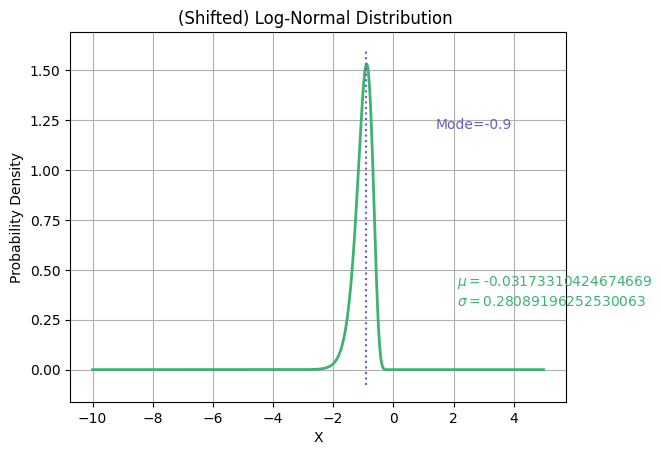

In [25]:
# mode of the log normal 
mode = log_norm_mode(MAP_mu, MAP_sigma)

# plot log normal of MAp parameters 
x_axis = np.arange(-10, 5, 0.01)
pdf_x_mu0 = reverse_shift_log_normal_pdf(x_axis, np.zeros(len(x_axis)), MAP_mu, MAP_sigma)

# Plot the log-normal probability density function (PDF)
xmin, xmax = plt.xlim()
plt.plot(x_axis, pdf_x_mu0, '-', linewidth=2, color='mediumseagreen')
plt.text(2.1, 0.32, f'$\sigma=${MAP_sigma}', color='mediumseagreen')
plt.text(2.1, 0.42, f'$\mu=${MAP_mu}', color='mediumseagreen')
#plt.text(7, 0.15, '$\sigma=0.25$', color='slateblue')

ymin, ymax = plt.ylim()
plt.vlines(-mode, ymin, ymax, color='slateblue', label='Log normal mode', linestyles='dotted')
plt.text(mode+0.5, 3*ymax/4, f'Mode={np.round(-mode,2)}', color='slateblue')

plt.title('(Shifted) Log-Normal Distribution ')
plt.xlabel('X')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

In [21]:
y_pred = np.dot(x, MAP_beta.T) + MAP_intercept
diagnosis_gap = y_pred.squeeze() - y.squeeze()

# update the dataframe 
df_dem_plus['diagnosis_gap']=diagnosis_gap

In [22]:
y_pred

array([2.12515484, 1.3651543 , 1.49457671, 1.45626322, 1.7647433 ,
       1.38045607, 1.49824277, 1.52692965, 1.72350081, 1.51928312,
       1.54480955, 1.52280723, 1.69407114, 1.95168082, 1.84005953,
       1.68403969, 1.92585965, 1.54003428, 1.50653207, 1.67849501,
       1.503759  , 1.29975369, 1.50477632, 1.57890918, 1.9216757 ,
       1.7605252 , 1.50428041, 1.85401471, 1.60475459, 2.22374222,
       1.60909689, 2.14708869, 0.98655494, 1.78662822, 1.80919517,
       2.10019327, 1.59754012, 1.38557402, 1.93923821, 1.54882064,
       2.0282099 , 1.01252503, 1.25212922, 1.41262601, 1.67696284,
       1.4046093 , 1.42449216, 1.70380271, 1.05455761, 1.6655265 ,
       1.73680458, 1.37091515, 1.37575299, 1.408872  , 1.52966969,
       1.73859419, 2.14353471, 1.36689479, 1.52695919, 1.89682123,
       1.42522893, 1.8386818 , 0.86634699, 1.914002  , 1.59584147,
       1.27412251, 1.67687043, 1.60619146, 1.49373966, 1.33844674,
       1.33118051, 1.84134576, 1.70802865, 1.49109576, 2.08605

In [23]:
most_bad_lads = np.argsort(diagnosis_gap)[-10:]
df_dem_plus.iloc[most_bad_lads, :][['area_name', 'diagnosis_gap']]

,area_name,diagnosis_gap
290,Brent,1.099286
34,Harrow,1.115497
215,East Lindsey,1.132193
134,Scarborough,1.139531
286,Torridge,1.140447
122,King's Lynn and West Norfolk,1.141311
271,Eden,1.149159
153,North Norfolk,1.168946
132,Ealing,1.200710
40,South Hams,1.221394


In [24]:
least_bad_lads = np.argsort(diagnosis_gap)[:10]
df_dem_plus.iloc[least_bad_lads, :][['area_name', 'diagnosis_gap']]

,area_name,diagnosis_gap
225,Southampton,0.372328
289,Lincoln,0.404155
77,Rochford,0.458935
3,Lancaster,0.459317
82,Brighton and Hove,0.470802
223,Islington,0.481442
76,Exeter,0.485218
32,Camden,0.501254
299,Newcastle upon Tyne,0.503596
138,Ashfield,0.514540
